In [2]:
import os
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer

# Scikit-learn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV

stemmer = EnglishStemmer()
#nltk.download('stopwords')

# [50p] Naive Bayes (NB), Logistic Regression (LR)
We chose the 20news-bydate dataset because it is already divided in 60% for training and 40% for testing which we can take 10% of the testing set for validation. Also this dataset is divided in training and testing by date, which eliminates the randomness in the selection of the sets making it easier for the cross-experiment comparison as mentioned in the webpage where this dataset is.

In [3]:
NEWS_TRAIN_FOLDER = '20news-bydate/20news-bydate-train/'

news_train = []
for folder in os.listdir(NEWS_TRAIN_FOLDER):
    for document in os.listdir(NEWS_TRAIN_FOLDER + folder):
        with open(NEWS_TRAIN_FOLDER + folder + '/' + document, 'r', encoding='utf-8', errors='ignore') as file:
            text = file.read()
            news_train.append({'category': folder, 'text': text})

df_news_train = pd.DataFrame(news_train)
df_news_train.head(5)



,category,text
0,sci.crypt,From: koontzd@phobos.lrmsc.loral.com (David Ko...
1,sci.crypt,From: gtoal@gtoal.com (Graham Toal)\nSubject: ...
2,sci.crypt,From: tcmay@netcom.com (Timothy C. May)\nSubje...
3,sci.crypt,From: artmel@well.sf.ca.us (Arthur Melnick)\nS...
4,sci.crypt,From: amolitor@nmsu.edu (Andrew Molitor)\nSubj...


In [4]:
NEWS_TEST_FOLDER = '20news-bydate/20news-bydate-test/'

news_test = []
for folder in os.listdir(NEWS_TEST_FOLDER):
    for document in os.listdir(NEWS_TEST_FOLDER + folder):
        with open(NEWS_TEST_FOLDER + folder + '/' + document, 'r', encoding='utf-8', errors='ignore') as file:
            text = file.read()
            news_test.append({'category': folder, 'text': text})

df_news_test = pd.DataFrame(news_test)
df_news_test.head(5)

,category,text
0,sci.crypt,From: pmetzger@snark.shearson.com (Perry E. Me...
1,sci.crypt,From: Borut.B.Lavrencic@ijs.si\nSubject: Re: K...
2,sci.crypt,From: stan@tacobel.UUCP (stan)\nSubject: Re: O...
3,sci.crypt,From: schlege@lips.ecn.purdue.edu (Kevin L Sch...
4,sci.crypt,From: zrepachol@cc.curtin.edu.au (Paul Repacho...


/home/oso/dev/NLP_HW2/.conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/oso/dev/NLP_HW2/.conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/oso/dev/NLP_HW2/.conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/oso/dev/NLP_HW2/.conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

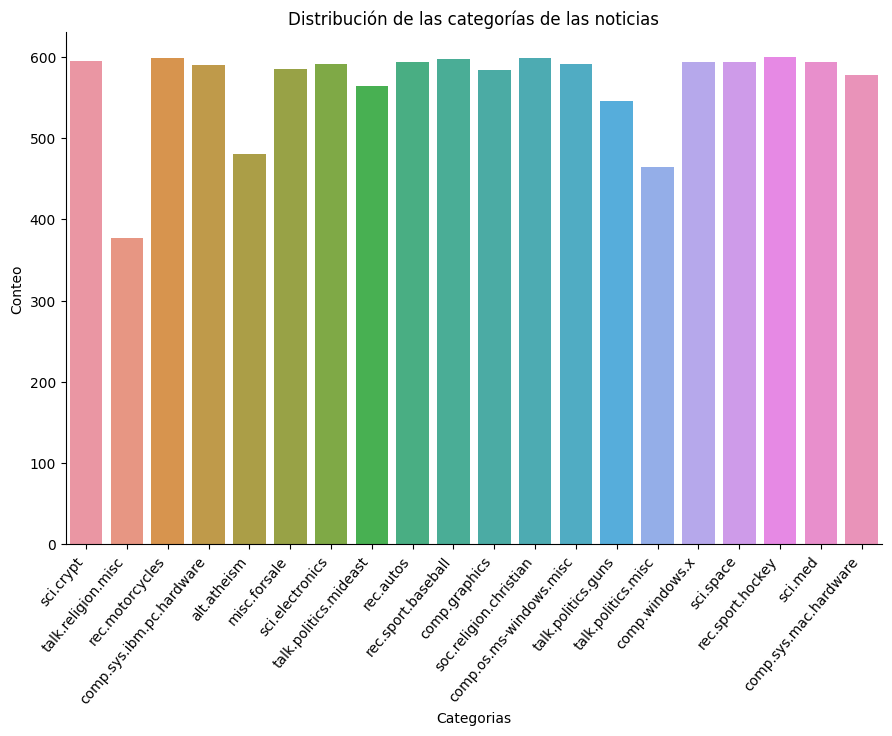

In [5]:
sns.catplot(x='category', kind='count', data=df_news_train)
plt.title('Distribución de las categorías de las noticias')
plt.xlabel('Categorias')
plt.ylabel('Conteo')
plt.xticks(rotation=45)
plt.gcf().set_size_inches(12, 6)
# Show the name of the categories with rotation 45 and shifted to the left
plt.xticks(range(20), df_news_train['category'].unique(), rotation=50, ha='right')
plt.show()

Classes are relatively balanced in terms of documents per class, which is good for the training of the classifier. The only classes with less that 500 documents are talk.religion.misc, alt.atheism and talk.politics.misc.

### Text Processing Pipeline
We identified that every news had many headers, which vary in size and in naming. Nevertheless, all news text start after an empty line after all the previous headers, so our text processing basically does that among other things like removing punctuation, numbers, stopwords, etc. Also, we used the SnowballStemmer to stem the words in the text for reducing the number of words in the vocabulary.

In [6]:
def text_processing(text):
    # Step 1: Remove all the lines before the news real content
    lines = str(text).splitlines()
    i = 0
    processed_text = ''
    while i < len(lines):
        if lines[i] == '':
            processed_text = ' '.join(lines[i + 1:])
            break
        i += 1
    # Step 2: Remove all the special characters (maintain only words)
    processed_text = re.sub(r'\W', ' ', processed_text)
    # Step 3: Remove all single characters
    processed_text = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_text)
    # Step 4: Remove single characters from the start
    processed_text = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_text)
    # Step 5: Substituting multiple spaces with single space
    processed_text = re.sub(r'\s+', ' ', processed_text)
    # Step 6: Lowercase
    processed_text = processed_text.lower()
    # Step 7: Stemming
    processed_text = " ".join([stemmer.stem(word) for word in processed_text.split()])
    return processed_text



In [7]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [8]:
train_raw_news = df_news_train['text'].values
train_news_labels = df_news_train['category'].values

train_processed_news = []
for text in train_raw_news:
    train_processed_news.append(text_processing(text))

In [9]:
print("Original:")
print(df_news_train['text'][121][:500], "...")
print("-----------------------------------\nProcessed:")
print(train_processed_news[121][:500], "...")

Original:
From: amanda@intercon.com (Amanda Walker)
Subject: Re: Screw the people, crypto is for hard-core hackers & spooks 
	only
Organization: InterCon Systems Corporation - Herndon, VA  USA
Lines: 35
Distribution: world
Reply-To: amanda@intercon.com (Amanda Walker)
NNTP-Posting-Host: chaos.intercon.com
X-Newsreader: InterCon TCP/Connect II 1.1

jhart@agora.rain.com (Jim Hart) writes:
> You don't care that people are being lied to, fooled into believing the 
> chip gives "privacy" when it fact it allows ...
-----------------------------------
Processed:
jhart agora rain com jim hart write you don care that peopl are be lie to fool into believ the chip give privaci when it fact it allow wiretap it doe give privaci just not absolut privaci the announc was veri up front about this and about allow wiretap how is this fool anyon are you so smart that you know when you re talk to somebodi who has wiretap chip on their phone instead of privaci chip with privat key sure the two don interoper

In [10]:
test_raw_news = df_news_test['text'].values
test_news_labels = df_news_test['category'].values

test_processed_news = []
for text in test_raw_news:
    test_processed_news.append(text_processing(text))

In [11]:
print("Original:")
print(df_news_test['text'][0][:500], "...")
print("-----------------------------------\nProcessed:")
print(test_processed_news[0][:500], "...")

Original:
From: pmetzger@snark.shearson.com (Perry E. Metzger)
Subject: Re: Tempest
Organization: Partnership for an America Free Drug
Distribution: na
Lines: 11

whughes@lonestar.utsa.edu (William W. Hughes) writes:
>Hell, just set up a spark jammer, or some other _very_ electrically-noisy
>device.

As I've noted, you can likely get around that with a directional
sensor. Phased array systems could completely defeat this scheme.

--
Perry Metzger		pmetzger@shearson.com
--
Laissez faire, laissez passer. Le ...
-----------------------------------
Processed:
whugh lonestar utsa edu william hugh write hell just set up spark jammer or some other _very_ electr noisi devic as ve note you can like get around that with direct sensor phase array system could complet defeat this scheme perri metzger pmetzger shearson com laissez fair laissez passer le mond va de lui meme ...


## Text Representation
We are going to use two representations: CountVectorizer and TfIdfVectorizer. For each representation we are going to train two classifiers: Naive Bayes and Logistic Regression. We are going to compare the results of each classifier with each representation and then compare the best results of each representation.
### Bag of Words (Count Vectorizer)
First we are using the CountVectorizer from sklearn to create a bag of words representation of the text. We are limiting the vocabulary to 5000 words, which is a good number for the size of the dataset. 

In [50]:
countVectorizer = CountVectorizer(max_features=5000, stop_words=stopwords.words('english'))

X_train = countVectorizer.fit_transform(train_processed_news).toarray()
y_train = train_news_labels

test_vectorized_news = countVectorizer.transform(test_processed_news).toarray()
X_val, X_test, y_val, y_test = train_test_split(test_vectorized_news, test_news_labels, test_size=0.75, random_state=42)

#### Naive Bayes

In [13]:
nb = MultinomialNB()
nb.fit(X_train, y_train)


MultinomialNB()

In [14]:
predictions = nb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))

Accuracy: 0.7314568950256682


The accuraccy is currently 0.73. We trained NB also with all the features with more than 2 counts and the accuracy was 0.76, but the training time was much higher (1 min 20sec vs 7 seconds). So we are preferring using the 5000 word representation for simplicity and speed, without sacrificing much accuracy.

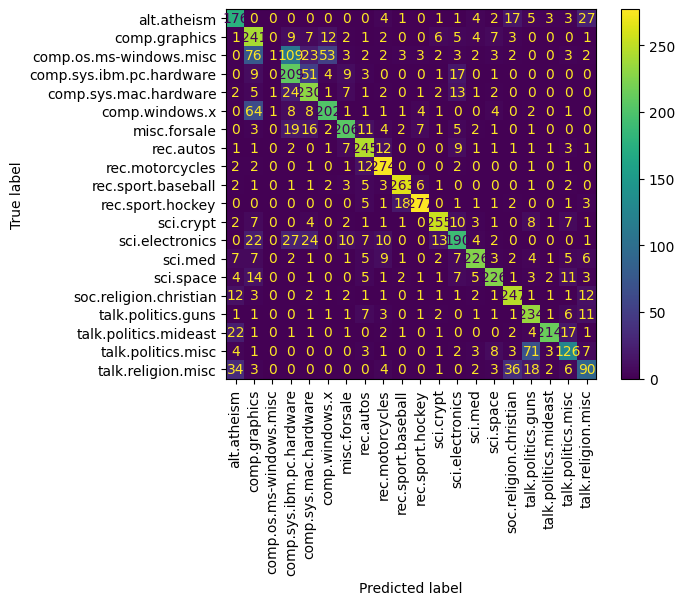

In [15]:
cm = confusion_matrix(y_test, predictions, labels=nb.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb.classes_)
# x axis: predicted labels rotated 45 degrees and shifted to the left
# y axis: true labels
disp.plot(xticks_rotation=90)

#### Logistic Regression

In [16]:
# Train Logistic Regression
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

/home/oso/dev/NLP_HW2/.conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [17]:
predictions = logistic_regression.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))

Accuracy: 0.7190653212958046


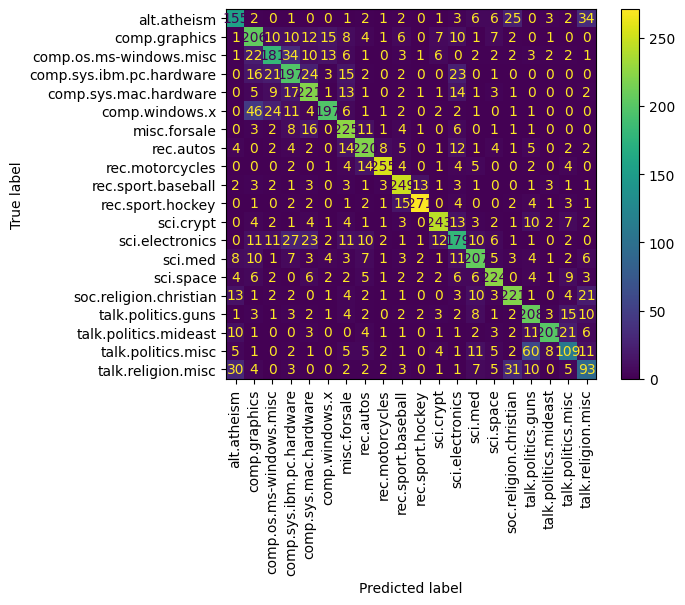

In [18]:
cm = confusion_matrix(y_test, predictions, labels=logistic_regression.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logistic_regression.classes_)
disp.plot(xticks_rotation=90)

Currently for our testing set we have an accuracy of 0.73 with Naive Bayes and 0.71 with Logistic Regression using the CountVectorizer. Now we are going to use the TfIdfVectorizer to see if we can improve the accuracy.

### Tf-Idf Vectorizer


In [19]:
tf_idf_vectorizer = TfidfVectorizer(max_features=5000, stop_words=stopwords.words('english'))

X_train = tf_idf_vectorizer.fit_transform(train_processed_news).toarray()
y_train = train_news_labels

test_vectorized_news = tf_idf_vectorizer.transform(test_processed_news).toarray()
X_val, X_test, y_val, y_test = train_test_split(test_vectorized_news, test_news_labels, test_size=0.75, random_state=42)

#### Naive Bayes

In [48]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [51]:
predictions = nb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

Accuracy: 0.7774827403080191
                          precision    recall  f1-score   support

             alt.atheism       0.69      0.63      0.66       244
           comp.graphics       0.62      0.78      0.69       301
 comp.os.ms-windows.misc       0.68      0.75      0.71       292
comp.sys.ibm.pc.hardware       0.68      0.75      0.71       304
   comp.sys.mac.hardware       0.78      0.76      0.77       292
          comp.windows.x       0.86      0.72      0.78       299
            misc.forsale       0.86      0.74      0.79       280
               rec.autos       0.81      0.89      0.85       287
         rec.motorcycles       0.91      0.89      0.90       296
      rec.sport.baseball       0.87      0.92      0.89       291
        rec.sport.hockey       0.94      0.91      0.93       310
               sci.crypt       0.87      0.90      0.88       304
         sci.electronics       0.73      0.63      0.68       310
                 sci.med       0.88      0.81 

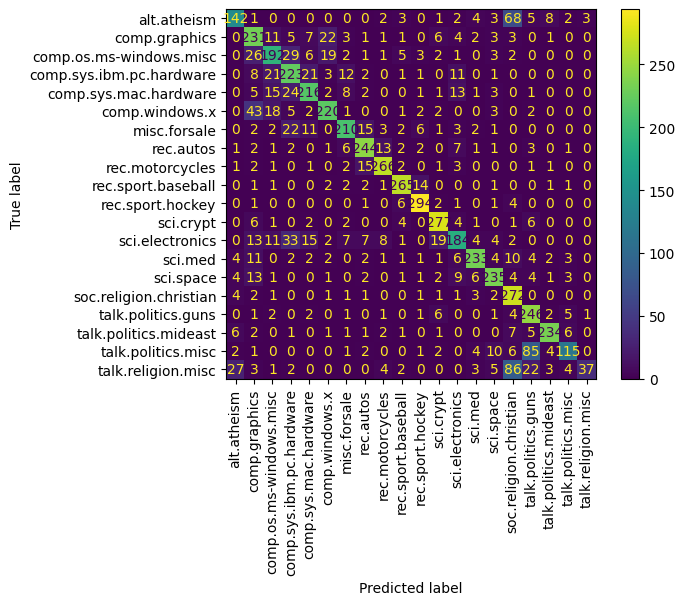

In [22]:
cm = confusion_matrix(y_test, predictions, labels=nb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb.classes_)
disp.plot(xticks_rotation=90)

#### Logistic Regression

In [54]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [55]:
predictions = lr.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

Accuracy: 0.7183572313683838
                          precision    recall  f1-score   support

             alt.atheism       0.66      0.64      0.65       244
           comp.graphics       0.60      0.68      0.64       301
 comp.os.ms-windows.misc       0.68      0.62      0.65       292
comp.sys.ibm.pc.hardware       0.60      0.65      0.62       304
   comp.sys.mac.hardware       0.66      0.76      0.70       292
          comp.windows.x       0.82      0.66      0.73       299
            misc.forsale       0.67      0.80      0.73       280
               rec.autos       0.74      0.77      0.75       287
         rec.motorcycles       0.90      0.86      0.88       296
      rec.sport.baseball       0.80      0.86      0.83       291
        rec.sport.hockey       0.92      0.87      0.90       310
               sci.crypt       0.85      0.80      0.82       304
         sci.electronics       0.60      0.58      0.59       310
                 sci.med       0.73      0.72 

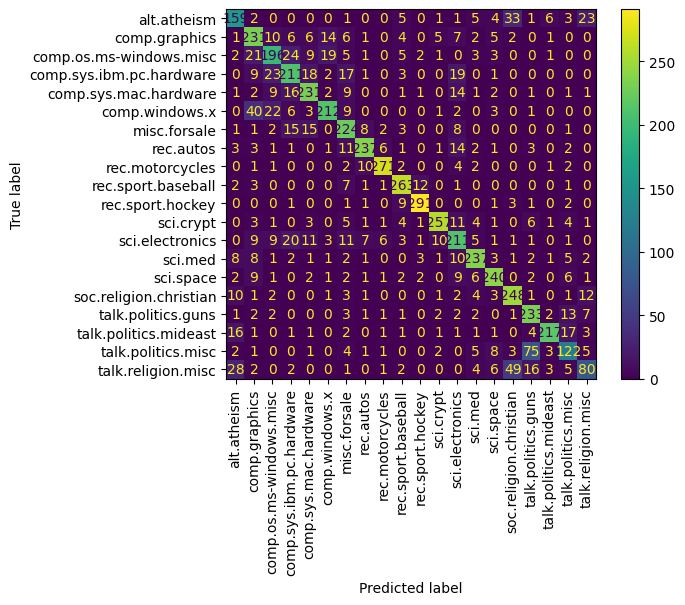

In [25]:
cm = confusion_matrix(y_test, predictions, labels=lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot(xticks_rotation=90)

Using the TfIdfVectorizer we got an accuracy of 0.77 for Naive Bayes and 0.71 for Logistic Regression. So we can see that using the TfIdfVectorizer we got a better accuracy for both classifiers, and in less time.

## Cross Validation Technique
Cross-validation is a fundamental technique used in machine learning to assess the performance of a predictive model, estimate its generalization capabilities, and reduce the risk of overfitting. It does so by partitioning the available data into multiple subsets, training and testing the model on different subsets, and then aggregating the results. Here's how cross-validation works step by step:

1. Partition the available data into k subsets, typically by dividing it into k equal-sized chunks. Each subset is called a fold.

2. For each fold i, train a model on all the data except the data in fold i. Then test the model on the data in fold i. Record the performance score for model i.

3. Performance is typically measured using accuracy, precision, recall, F1 score, or some other useful measure. The performance measure is often called the evaluation metric.

4. Repeat steps 2 and 3 k times, using a different fold as the test set each time.

5. Once all k iterations are complete, the performance metrics from each fold are typically averaged to provide an overall assessment of the model's performance. For classification problems, you might calculate metrics like accuracy, precision, recall, and F1-score. For regression problems, you might use metrics like mean squared error or mean absolute error.

### Cross Validation benefits

Cross-validation is a powerful technique for assessing the generalization capabilities of a model and reducing the risk of overfitting. It has several benefits:

1. Robust Performance Estimation: Cross-validation provides a more reliable estimate of a model's performance compared to a single train/test split. It helps you assess how well your model generalizes to unseen data.

2. Reduced Overfitting: By training and testing the model multiple times on different subsets of data, cross-validation can help detect and mitigate overfitting issues.

3. Optimizing Hyperparameters: Cross-validation is often used for hyperparameter tuning, where different combinations of hyperparameters are evaluated on various validation sets, helping you find the best hyperparameters for your model.


Knowing this, we are going to use the cross validation technique to find the best hyperparameters for our classifiers using a 10-fold cross validation. We are going to use the GridSearchCV from sklearn to do this.

## 10 Fold Cross Validation

First we are going to join the training and validation sets to train the classifiers with the best hyperparameters. Then we are going to use the test set to test the classifiers.


In [26]:
tf_idf_vectorizer = TfidfVectorizer(max_features=5000, stop_words=stopwords.words('english'))

train_val_vectorized_news = tf_idf_vectorizer.fit_transform(train_processed_news).toarray()

test_vectorized_news = tf_idf_vectorizer.transform(test_processed_news).toarray()

X_val, X_test, y_val, y_test = train_test_split(test_vectorized_news, test_news_labels, test_size=0.75, random_state=42)

# Join train and validation sets
X_train = np.concatenate((X_train, X_val))
y_train = np.concatenate((y_train, y_val))

#### Finding Naive Bayes best hyperparameters

In [27]:
nb = MultinomialNB()

parameters = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]} # For testing the laplace smoothing parameter

clf = GridSearchCV(nb, parameters, cv=10, scoring='accuracy', verbose=1)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Best parameters set found on development set:
{'alpha': 0.01}


Now we are going to retrain the Naive Bayes with this alpha value and see if it improves the accuracy.

In [28]:
nb = MultinomialNB(alpha=clf.best_params_['alpha'])
nb.fit(X_train, y_train)

MultinomialNB(alpha=0.01)

In [29]:
predictions = nb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))

Accuracy: 0.8038590901044432


Compared to the previous accuracy of 0.76, we got an accuracy of 0.80, which is a small improvement but significant as we only changed the alpha value from 1 \( default\) to 0.1.

                          precision    recall  f1-score   support

             alt.atheism       0.77      0.71      0.74       244
           comp.graphics       0.64      0.76      0.69       301
 comp.os.ms-windows.misc       0.70      0.72      0.71       292
comp.sys.ibm.pc.hardware       0.71      0.74      0.73       304
   comp.sys.mac.hardware       0.77      0.75      0.76       292
          comp.windows.x       0.83      0.75      0.79       299
            misc.forsale       0.81      0.74      0.77       280
               rec.autos       0.83      0.85      0.84       287
         rec.motorcycles       0.90      0.93      0.91       296
      rec.sport.baseball       0.93      0.95      0.94       291
        rec.sport.hockey       0.95      0.96      0.96       310
               sci.crypt       0.87      0.91      0.89       304
         sci.electronics       0.76      0.67      0.71       310
                 sci.med       0.89      0.84      0.86       289
         

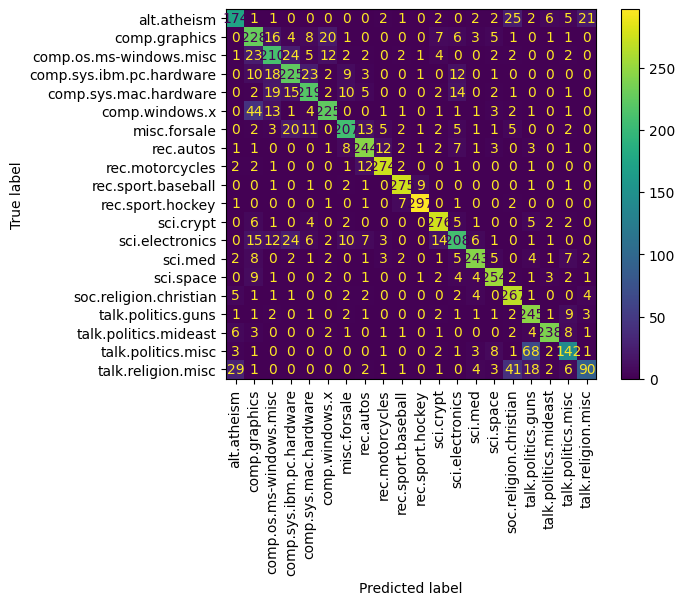

In [30]:
# Report precision, recall, and F1-score with the macro and micro average
print(classification_report(y_test, predictions, labels=nb.classes_))

cm = confusion_matrix(y_test, predictions, labels=nb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb.classes_)
disp.plot(xticks_rotation=90)

#### Finding Logistic Regression best hyperparameters

Scikit Learn LogisticRegression() doesnt let us change the learning rate. So we tried with finding the best C value for the Logistic Regression. We also tried the SGDClassifier with the loss set to log and trying to find the best alpha value.

In [31]:
lr = SGDClassifier(loss='log_loss', max_iter=1000) # log_loss is the logistic regression loss function
lr.fit(X_train, y_train)

predictions = lr.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions, labels=lr.classes_))

Accuracy: 0.7957160559391042
                          precision    recall  f1-score   support

             alt.atheism       0.74      0.69      0.72       244
           comp.graphics       0.75      0.74      0.75       301
 comp.os.ms-windows.misc       0.76      0.69      0.72       292
comp.sys.ibm.pc.hardware       0.68      0.76      0.72       304
   comp.sys.mac.hardware       0.79      0.78      0.79       292
          comp.windows.x       0.83      0.76      0.79       299
            misc.forsale       0.65      0.80      0.72       280
               rec.autos       0.86      0.86      0.86       287
         rec.motorcycles       0.89      0.95      0.92       296
      rec.sport.baseball       0.84      0.92      0.88       291
        rec.sport.hockey       0.90      0.95      0.93       310
               sci.crypt       0.90      0.89      0.90       304
         sci.electronics       0.76      0.66      0.70       310
                 sci.med       0.86      0.85 

In [41]:
lr = LogisticRegression(max_iter=100)

parameters = {
    'C': [0.5, 1.0],
}

clf = GridSearchCV(lr, parameters, cv=5, scoring='accuracy')
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_)

Best parameters set found on development set:
{'C': 1.0}


In [42]:
lr = LogisticRegression(max_iter=1000, C=clf.best_params_['C'])

lr.fit(X_train, y_train)

predictions = lr.predict(X_test)

print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions, labels=lr.classes_))

Accuracy: 0.8052752699592848
                          precision    recall  f1-score   support

             alt.atheism       0.75      0.68      0.71       244
           comp.graphics       0.69      0.78      0.73       301
 comp.os.ms-windows.misc       0.73      0.73      0.73       292
comp.sys.ibm.pc.hardware       0.73      0.74      0.73       304
   comp.sys.mac.hardware       0.81      0.81      0.81       292
          comp.windows.x       0.86      0.77      0.81       299
            misc.forsale       0.72      0.81      0.76       280
               rec.autos       0.86      0.86      0.86       287
         rec.motorcycles       0.93      0.93      0.93       296
      rec.sport.baseball       0.87      0.93      0.90       291
        rec.sport.hockey       0.95      0.94      0.95       310
               sci.crypt       0.92      0.88      0.90       304
         sci.electronics       0.72      0.69      0.71       310
                 sci.med       0.83      0.87 

In [44]:
lr = SGDClassifier(loss='log_loss', max_iter=500)

parameters = {
    'alpha': [0.0001, 0.001, 0.01],
}

clf = GridSearchCV(lr, parameters, cv=5, scoring='accuracy')

clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_)

Best parameters set found on development set:
{'alpha': 0.0001}


In [46]:
lr = SGDClassifier(loss='log_loss', max_iter=1000, alpha=clf.best_params_['alpha'])

lr.fit(X_train, y_train)

predictions = lr.predict(X_test)

print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions, labels=lr.classes_))

Accuracy: 0.7939458311205523
                          precision    recall  f1-score   support

             alt.atheism       0.72      0.68      0.70       244
           comp.graphics       0.66      0.80      0.72       301
 comp.os.ms-windows.misc       0.76      0.71      0.73       292
comp.sys.ibm.pc.hardware       0.69      0.76      0.72       304
   comp.sys.mac.hardware       0.82      0.76      0.79       292
          comp.windows.x       0.88      0.73      0.79       299
            misc.forsale       0.62      0.82      0.70       280
               rec.autos       0.82      0.86      0.84       287
         rec.motorcycles       0.94      0.92      0.93       296
      rec.sport.baseball       0.91      0.88      0.89       291
        rec.sport.hockey       0.93      0.96      0.95       310
               sci.crypt       0.89      0.89      0.89       304
         sci.electronics       0.72      0.67      0.69       310
                 sci.med       0.83      0.86 

## Best Model
All the models were trained with the tf-idf representation as it gave us the best results.

After using cross-validation for the Multinomial Naive Bayes, we found that the best alpha value is 0.01. And when testing the model with the test set we got an accuracy of 80.3%, which is a small improvement compared to the previous accuracy of 0.76.

For the Logistic Regression, we found that the best C value is 0.1. And when testing the model with the test set we got an accuracy of 80.5%, which is a small improvement compared to the previous accuracy of 0.77.

For the SGDClassifier with log loss, we found that the best alpha value is 0.0001. But when implementing it accuracy decreased from 79.5 to 79.3, so we are not going to use this classifier.

So we can see that the best model is the Logistic Regression with the C value of 0.1, which gave us an accuracy of 80.5%. But Naive Bayes is also a good model with an accuracy of 80.3% and it is much faster to train.